# Assignment 5: Topic Models

# sh2432
Due: Tuesday, November 5.

This assignment has three problems. The first is about Bayesian inference. The second two are about topic models. You will first work with abstracts of scientific articles. These abstracts are obtained from arXiv.org, an open access repository for e-prints of articles in scientific fields maintained by Cornell University. You will then work with a collection of movie plots.

*For your convenience, we have separated the problems into three notebooks: assn5_problem1.ipynb, assn5_problem2.ipynb, and assn5_problem3.ipynb. Submit your solutions in these three notebooks, printing out each as a separate pdf.*

We provide significant "starter code" as discussed in lecture. We then ask you build topic models using the Python library gensim, and do some analysis over the topics obtained.

We ask that you please at least start the assignment right away. If you have any difficulties running gensim we would like to know!


# Problem 3: Topic Models on Movie Plots 

In this problem we will continue working with topic models, but this time with a new dataset. Instead of abstracts of scientific articles, we will create topic models over movie plot descriptions. This is a dataset containing descriptions of movies from Wikipedia. The dataset was [obtained](https://www.kaggle.com/jrobischon/wikipedia-movie-plots) from Kaggle, an online community of data scientists. We again provide extensive starter code to process the data.

Spoiler alert! We will use the movie "[Husbands and Wives](https://en.wikipedia.org/wiki/Husbands_and_Wives)" as a running example...

[<img width=200 src="https://upload.wikimedia.org/wikipedia/en/7/70/Husbands_moviep.jpg">](https://en.wikipedia.org/wiki/Husbands_and_Wives)


In [59]:
import numpy as np
import re
import gensim
import pandas as pd
from collections import Counter

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
logging.root.level = logging.CRITICAL 

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# direct plots to appear within the cell, and set their style
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

This time around, the movie plot descriptions are in a CSV format in `movie_plots.csv`. The file is hosted on the Amazon Web Service s3. We'll use the `datascience` package to read this CSV file.



In [60]:
filename = "https://s3.amazonaws.com/sds171/labs/lab07/movie_plots.csv"
data = pd.read_csv(filename)
data.head(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


To make the data a little more manageable, we restrict to movies that were released after 1980. We then pull out the titles and plots as lists, for convenience.

In [61]:
movies = data[data['Release Year'] > 1980]
titles = list(movies['Title'])
plots = list(movies['Plot'])

In [62]:
movies.head()


,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
9796,1981,Absence of Malice,American,Sydney Pollack,"Paul Newman, Sally Field, Bob Balaban, Melinda...",drama,https://en.wikipedia.org/wiki/Absence_of_Malice,Miami liquor wholesaler Michael Gallagher (Pau...
9797,1981,All Night Long,American,Jean-Claude Tramont,"Gene Hackman, Barbra Streisand, Diane Ladd, De...",comedy,https://en.wikipedia.org/wiki/All_Night_Long_(...,"George Dupler (Gene Hackman), a married man ne..."
9798,1981,...All the Marbles,American,Robert Aldrich,Peter Falk,"comedy, drama",https://en.wikipedia.org/wiki/...All_the_Marbles,Harry is the manager of a tag team of gorgeous...
9799,1981,The Amateur,American,Charles Jarrott,"John Savage, Christopher Plummer",spy,https://en.wikipedia.org/wiki/The_Amateur_(198...,"When his fiancée is murdered by terrorists, a ..."
9800,1981,American Pop,American,Ralph Bakshi,"Lisa Jane Persky, Ron Thompson","drama, animated",https://en.wikipedia.org/wiki/American_Pop,"In Imperial Russia during the late 1890s, a ra..."


In [64]:
sample = 2015
print("Number of movies: %d\n" % movies.shape[0])
print("Plot of \"%s\":\n" % titles[2015])
print(plots[2015])


Number of movies: 19994

Plot of "Husbands and Wives":

The film is about two couples: Jack (Pollack) and Sally (Davis), and Gabe (Allen) and Judy (Farrow). The film starts when Jack and Sally arrive at Gabe and Judy's apartment and announce their separation. Gabe is shocked, but Judy takes the news personally and is very hurt. Still confused, they go out for dinner at a Chinese restaurant.
A few weeks later Sally goes to the apartment of a colleague. They plan to go out together to the opera and then to dinner. Sally asks if she can use his phone, and calls Jack. Learning from him that he has met someone, she accuses him of having had an affair during their marriage.
Judy and Gabe are introduced to Jack's new girlfriend, Sam, an aerobics trainer. While Judy and Sam shop, Gabe calls Jack's new girlfriend a "cocktail waitress" and tells him that he is crazy for leaving Sally for her. About a week later, Judy introduces Sally to Michael (Neeson), Judy's magazine colleague who she clearly

This plot description is from the movie "[Husbands and Wives](https://en.wikipedia.org/wiki/Husbands_and_Wives)"

We don't have LaTeX markup in these documents, but we'll still use some regular expressions to do some simpe pre-processing of punctuation. There are lots of names in the plot descriptions, so we'll remove all the words that have a capitalized first letter. This will remove lots of non-name words as well, but this'll be sufficient for our goal of building a basic topic model.

In [65]:

# replace '-' with ' ', then remove punctuation
plots = [re.sub('-', ' ', plot) for plot in plots]
plots = [re.sub('[^\w\s]', '', plot) for plot in plots]

# remove tokens with a capitalized first letter 
# (broad stroke to remove names)
plots = [re.sub('[A-Z]\w*', '', plot) for plot in plots]
# replace multiple spaces by a single space
plots = [re.sub('[ ]+', ' ', plot) for plot in plots]

print(plots[sample])


 film is about two couples and and and film starts when and arrive at and apartment and announce their separation is shocked but takes the news personally and is very hurt confused they go out for dinner at a restaurant
 few weeks later goes to the apartment of a colleague plan to go out together to the opera and then to dinner asks if she can use his phone and calls from him that he has met someone she accuses him of having had an affair during their marriage
 and are introduced to new girlfriend an aerobics trainer and shop calls new girlfriend a cocktail waitress and tells him that he is crazy for leaving for her a week later introduces to magazine colleague who she clearly is interested in herself asks out and they begin dating is smitten but is dissatisfied with the relationship
 has developed a friendship with a young student of his and has her read the manuscript of his novel comments on its brilliance but has several criticisms to which reacts defensively
 a party learns from a

Now, we further process each plot description by converting it to lower case, stripping leading and trailing white space, and then tokenizing by splitting on spaces.

In [66]:
plots_tok = []
for plot in plots:
    processed = plot.lower().strip().split(' ')
    plots_tok.append(processed)

### 3.1 Further cleaning

As in problem 2, we will remove tokens that have digits, possessives or contractions, or are empty strings.
- `is_numeric(string)` checks if `string` has any numbers
- `has_poss_contr(string)` checks if `string` has possessives or contractions
- `empty_string(string)` checks if `string` is an empty string
- `remove_string(string)` checcks if `string` should be removed

In [67]:
def is_numeric(string):
    return any(i.isdigit() for i in string) 

def has_poss_contr(string):
    return any(char=="'" for char in string)      

def empty_string(string):
    return not string.strip()

def remove_string(string):
    return is_numeric(string) or has_poss_contr(string) or empty_string(string)

In [68]:
temp = []
for plot in plots_tok:
    filtered = []
    for token in plot:
        if not remove_string(token):
            filtered.append(token)
    temp.append(filtered)
plots_tok = temp

Recall that to build topic models, we require the following components:
- A vocabulary of tokens that appear across all documents.
- A mapping of those tokens to a unique integer identifier, because topic model algorithms treat words by these identifiers, and not the strings themselves. For example, we represent `'epidemic'` as `word2id['epidemic'] = 50`
- The corpus, where each document in the corpus is a collection of tokens, where each token is represented by the identifier and the number of times it appears in the document. For example, in the first document above the token `'epidemic'`, which appears twice, is represented as `(50, 2)`

Now we will build a vocabulary representing the tokens that have appeared across all the plot descriptions we have. 


Recall that we can use the `Counter` class to build the vocabulary. The `Counter` is an extension of the Python dictionary, and also has key-value pairs. For the `Counter`, keys are the objects to be counted, while values are their counts.

In [69]:
vocab = Counter()
for plot in plots_tok:
    vocab.update(plot)

print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 56501


Recall that removing rare words helps prevent our vocabulary from being too large. Many tokens appear only a few times across all the plot descriptions. Keeping them in the vocabulary increases subsequent computation time. Furthermore, their presence tends not to carry much significance for a document, since they can be considered as anomalies.

We remove rare words by only keeping tokens that appear more than 25 times across all plot descriptions.

In [70]:
tokens = []
for token in vocab.elements():
    if vocab[token] >= 50:
        tokens.append(token)
vocab = Counter(tokens)

print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 7791


Recall that stop words are defined as very common words such as `'the'` and `'a'`. Removing stop words is important because their presence also does not carry much significance, since they appear in all kinds of texts.

We will remove stop words by removing the 200 most common tokens across all the plot descriptions.

In [71]:
stop_words = []
for item in vocab.most_common(200):
    stop_word = item[0]
    stop_words.append(stop_word)
tokens = []
for token in vocab.elements():
    if token not in stop_words:
        tokens.append(token)
vocab = Counter(tokens)

print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 7591


Now we create a mapping for tokens to unique identifiers. 

In [72]:
items = vocab.items()
id2word = {}
word2id = {}
idx = 0
for word, count in vocab.items():
    id2word[idx] = word
    word2id[word] = idx
    idx += 1
    
print("Number of tokens mapped: %d" % len(id2word))
print("Identifier for 'photograph': %d" % word2id['photograph'])
print("Word for identifier %d: %s" % (word2id['photograph'], id2word[word2id['photograph']]))

Number of tokens mapped: 7591
Identifier for 'photograph': 1780
Word for identifier 1780: photograph


Now, we will remove, for each plot description, the tokens that are not found in our vocabulary.

In [73]:
temp = []
for plot in plots_tok:
    filtered = []
    for token in plot:
        if token in vocab:
            filtered.append(token)
    temp.append(filtered)
plots_tok = temp

Let's create the corpus. Recall that the corpus should have the format
```
[(1841, 2), (2095, 2), (2096, 1), (2097, 1), (2098, 2), (105, 2), (2099, 1), (2100, 1), (270, 2), (1763, 1), (1870, 1), (2101, 1), (2017, 4), (633, 1), (1270, 1), (1093, 1), (2102, 1), (1197, 1), (113, 1), (1583, 1), (2103, 1), (2104, 2), (2105, 1), (873, 1), (1950, 1), (107, 1), (2106, 1), (2107, 1), (116, 1), (1436, 1), (62, 1), (2108, 1), (213, 1), (2109, 1), (1205, 1), (2110, 1), (1042, 1), (1275, 1), (1259, 1), (1342, 1), (2111, 1), (440, 1), (1662, 1), (374, 1), (663, 1)]
```

where each element is a pair containing the identifier for the token and the count of that token in just that plot description.

In [74]:
corpus = []
for plot in plots_tok:
    plot_count = Counter(plot)
    corpus_doc = []
    for item in plot_count.items():
        pair = (word2id[item[0]], item[1])
        corpus_doc.append(pair)
    corpus.append(corpus_doc)

print("Plot, tokenized:\n", plots_tok[sample], "\n")
print("Plot, in corpus format:\n", corpus[sample])

Plot, tokenized:
 ['couples', 'arrive', 'apartment', 'announce', 'separation', 'shocked', 'news', 'personally', 'very', 'hurt', 'confused', 'dinner', 'few', 'weeks', 'apartment', 'colleague', 'plan', 'opera', 'dinner', 'use', 'phone', 'calls', 'met', 'someone', 'accuses', 'affair', 'marriage\r\n', 'introduced', 'girlfriend', 'trainer', 'shop', 'calls', 'girlfriend', 'cocktail', 'waitress', 'crazy', 'leaving', 'week', 'introduces', 'magazine', 'colleague', 'clearly', 'interested', 'herself', 'begin', 'dating', 'smitten', 'dissatisfied', 'relationship\r\n', 'developed', 'friendship', 'student', 'read', 'manuscript', 'novel', 'comments', 'several', 'reacts', 'learns', 'seeing', 'someone', 'flies', 'jealous', 'rage', 'break', 'intense', 'argument', 'drives', 'bed', 'give', 'chance', 'leave\r\n', 'than', 'weeks', 'however', 'couple', 'dinner', 'times', 'dinner', 'argument', 'sharing', 'poetry', 'failed', 'pass', 'thinks', 'week', 'moves', 'seeing', 'birthday', 'music', 'box', 'present', 'ki

Now, we are ready to create our topic model!

We again use gensim, a Python library to create topic models. Also, we again use the algorithm called latent dirichlet allocation implemented in the gensim library. 

**This step takes about 2 minutes**

In [75]:
#%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

## Topics for Movies

Your task is now to carry out the same steps as for problem 2 (arXiv abstracts), but now for this dataset of movie plots

#### 3.2 Label the Topics
Label all the 10 topics with your interpretation of what the topics are. 

#### 3.3 Table of Topics for Movies
Create a function `create_movie_table(data, abstracts, corpus, lda_model)` which does the following:
- Goes through every movie plot and finds the most likely topic for that plot.
- Creates a table `movie_table` that has the following columns
    - `title`: the title of the movie
    - `topic`: the topic number of the most likely topic for each abstract
    - `label`: the topic label of that topic number, which you assigned in part 1
    - `prob`: the probability of that topic number
    - `plot`: a string containing the first 200 characters of the plot
- Show the first 10 rows of the table, then return the table

#### 3.4 Analysis for selected movies
Choose at least five movies, including 'Husbands and Wives' and discuss how the assignment of topics either does or does not make sense, according to your own understanding of the movies.
Note that Wikipedia pages are given for most of the movies in the original data. For example, 
[https://en.wikipedia.org/wiki/Absence_of_Malice](https://en.wikipedia.org/wiki/Absence_of_Malice) is the page for "Absence of Malice"

#### 3.5 Extra credit: Improve the model
For extra credit, improve the topic model by improving the processing of the data and the vocabulary, and selecting a more appropriate number of topics. Describe how your new model gives an improvement over the "quick and dirty" topic model built above.


In [76]:
num_topics = 10
num_words = 15
top_words = pd.DataFrame({'word rank': np.arange(1,num_words+1)})
for k in np.arange(num_topics): 
    topic = lda_model.get_topic_terms(k, num_words)
    words = [id2word[topic[i][0]] for i in np.arange(num_words)]
    probs = [topic[i][1] for i in np.arange(num_words)]
    top_words['topic %d' % k] = words

top_words


,word rank,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,1,boy,battle,students,movie,case,soo,even,found,ship,killing
1,2,child,power,members,world,murder,gang,know,appears,mission,manages
2,3,children,human,final,show,company,train,hee,apartment,crew,attack
3,4,name,soldiers,student,around,officer,town,never,suddenly,military,shot
4,5,learns,world,won,game,former,woo,too,inside,use,escapes
5,6,live,war,second,play,ho,run,very,phone,machine,arrive
6,7,brothers,army,win,dream,under,station,doesnt,killer,space,head
7,8,fathers,city,match,part,crime,owner,going,missing,bomb,save
8,9,past,form,high,different,working,four,much,revealed,planet,orders
9,10,suicide,villagers,forms,dreams,order,club,college,scene,alien,gun


In [77]:
sample = 10
lda_model.get_document_topics(corpus[sample])

[(0, 0.18637612),
 (1, 0.015655736),
 (2, 0.030495616),
 (3, 0.060890447),
 (4, 0.20066743),
 (5, 0.030396197),
 (6, 0.14360552),
 (7, 0.20851804),
 (8, 0.058227547),
 (9, 0.065167345)]

In [78]:
topic_dist = lda_model.get_document_topics(corpus[sample])
topics = [pair[0] for pair in topic_dist]
probabilities = [pair[1] for pair in topic_dist]
topic_dist_table = pd.DataFrame()
topic_dist_table['Topic'] = topics
topic_dist_table['Probabilities'] = probabilities
topic_dist_table

,Topic,Probabilities
0,0,0.186379
1,1,0.015651
2,2,0.030496
3,3,0.060890
4,4,0.200667
5,5,0.030398
6,6,0.143603
7,7,0.208519
8,8,0.058228
9,9,0.065168


In [79]:
t = np.argmax(probabilities)
print("Topic with highest probability: %d (%f)" % (t, probabilities[t]))

Topic with highest probability: 7 (0.208519)


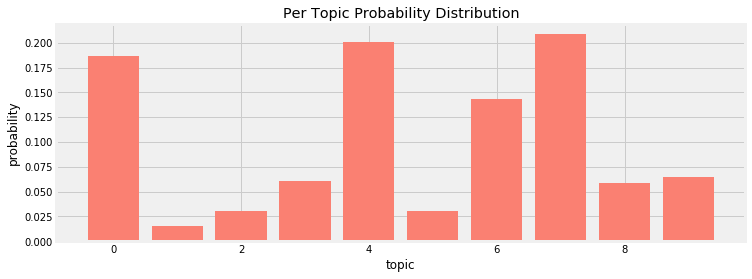

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(11,4)
plt.bar(topic_dist_table['Topic'], topic_dist_table['Probabilities'], align='center', alpha=1, color='salmon')
plt.xlabel('topic')
plt.ylabel('probability')
plt.title('Per Topic Probability Distribution')
plt.show()

In [81]:
top_words.columns=['word rank', 'Family drama', 'War', 'School drama', 'Fantasy',  'Crime','Gangster', 'Romance', 
                   'Horror', 'Science fiction', 'Action']
top_words

,word rank,Family drama,War,School drama,Fantasy,Crime,Gangster,Romance,Horror,Science fiction,Action
0,1,boy,battle,students,movie,case,soo,even,found,ship,killing
1,2,child,power,members,world,murder,gang,know,appears,mission,manages
2,3,children,human,final,show,company,train,hee,apartment,crew,attack
3,4,name,soldiers,student,around,officer,town,never,suddenly,military,shot
4,5,learns,world,won,game,former,woo,too,inside,use,escapes
5,6,live,war,second,play,ho,run,very,phone,machine,arrive
6,7,brothers,army,win,dream,under,station,doesnt,killer,space,head
7,8,fathers,city,match,part,crime,owner,going,missing,bomb,save
8,9,past,form,high,different,working,four,much,revealed,planet,orders
9,10,suicide,villagers,forms,dreams,order,club,college,scene,alien,gun


In [82]:
topic_num=list(range(0,10))
topic_label=['Family drama', 'War', 'School drama', 'Fantasy',  'Crime','Gangster', 'Romance', 
            'Horror', 'Science fiction', 'Action']
labels = pd.DataFrame()
labels['topic_num'] = topic_num
labels['topic_label'] = topic_label
labels 

,topic_num,topic_label
0,0,Family drama
1,1,War
2,2,School drama
3,3,Fantasy
4,4,Crime
5,5,Gangster
6,6,Romance
7,7,Horror
8,8,Science fiction
9,9,Action


In [83]:
def create_topic_table(data, plots, corpus, lda_model):
    
    # initialize some arrays
    title = []
    probs = []
    topic = []
    label = []
    short_movie = []
    for sample in np.arange(len(corpus)):
        topic_dist = lda_model.get_document_topics(corpus[sample])
        short_movie.append(plots[sample][0:200])
        topics = [pair[0] for pair in topic_dist]
        probabilities = [pair[1] for pair in topic_dist]
        t = np.argmax(probabilities)
        num = topics[t]
        lb= topic_label[num]
        probs.append(probabilities[t])
        topic.append(num)
        label.append(lb)
        

    table = pd.DataFrame()
    table['title'] = titles
    table['plot'] = short_movie
    # You'll need to add the topic, label, and probability for each abstract
    table['probability'] = probs
    table['topic label'] = label
    table['topic number']= topic
    return table

movie_table = create_topic_table(data, plots, corpus, lda_model)
movie_table.head(20)

,title,plot,probability,topic label,topic number
0,Absence of Malice,liquor wholesaler who is the son of a decease...,0.477833,Crime,4
1,All Night Long,a married man nearing middle age is demoted a...,0.550168,Romance,6
2,...All the Marbles,is the manager of a tag team of gorgeous lady...,0.179929,School drama,2
3,The Amateur,his fiancée is murdered by terrorists a crypt...,0.254682,Horror,7
4,American Pop,during the late 1890s a rabbis wife and her y...,0.244148,Gangster,5
5,An American Werewolf in London,backpackers and are trekking across the moors...,0.266071,Romance,6
6,Amy,is a dutiful housewife of the early 20th cent...,0.268717,Romance,6
7,Arthur,is a spoiled alcoholic from who likes to be d...,0.359720,Romance,6
8,Back Roads,is a 20 a trick hooker in night she entertain...,0.309545,Romance,6
9,Blow Out,in post production on a low budget slasher fi...,0.284828,Horror,7


In [84]:
pick = movie_table['title'].isin(['Husbands and Wives'])
movie_table.loc[pick]

,title,plot,probability,topic label,topic number
2015,Husbands and Wives,film is about two couples and and and film st...,0.567315,Romance,6


### 3.4
1. 'Husbands and Wives' is categorized as the Romance topic in the model, while on Wikipedia it is shown as a Comedy-drama. It is kind of make sense since the comedy is about romentic relationships. 
2. 'Amy' is categorized as the Romance topic in the model, while on Wikipedia it is listed as the documentary film about the life and death of British singer-songwriter Amy Winehouse. The model didn't give a very precise prediction of the topic.
3. 'Burned at the Stake' is categorized as the Horror topic in the model, which aligns with the discription on Wikipedia.
4. 'Charlie Chan and the Curse of the Dragon Queen' is categorized as the Crime topic in the model, while on Wikipedia it is listed as the comedy–mystery film. The model didn't give a very precise prediction of the topic.
5. 'American Pop' is categorized as the Gangster topic in the model, while on Wikipedia it is listed as an adult animated musical drama film. The model didn't give a very precise prediction of the topic.

### 3.5
To improve the topic mode, several actions can be taken:

1. when pre-processing the text, remove single characters like i, x, y, n in the contents; remove common used words like of, in, out; be mindful about lemmatization by converting a word to its root word.
2. adding more topics, can use 30 topics instead of 10.
3. use cross-validation to test the accuracy of the model.